In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [75]:
# Define variables
all_stims = np.hstack(np.array(trial_ts.stim_ts.dropna()))
stationary_stims = np.hstack(np.array(trial_ts.stationary_stims.dropna()))
movement_stims = np.hstack(np.array(trial_ts.movement_stims.dropna()))
choice = np.hstack(np.array(trial_ts.response.dropna()))

post_seconds = 0.15
bin_size = 0.010  # 10ms bins
start_time = all_stims[0]
end_time = all_stims[-1] + post_seconds

# Create time bins
time_bins = np.arange(start_time, end_time + bin_size, bin_size)
combined_bins = np.union1d(time_bins, all_stims)
combined_bins.sort()
time_bins = combined_bins

# Bin spike times for each unit
n_units = len(spike_times_per_unit)
n_bins = len(time_bins) - 1
binned_spike_rate = np.zeros((len(time_bins) - 1, n_units))

for unit_idx, spike_times in enumerate(spike_times_per_unit):
    counts, _ = np.histogram(spike_times, bins=time_bins)
    binned_spike_rate[:, unit_idx] = counts / bin_size

# Create stimulus indicator vectors
stim_indicator = np.zeros(len(time_bins) - 1)
stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
stim_indicator[stim_indices] = 1

stationary_stim_indicator = np.zeros(len(time_bins) - 1)
stationary_stim_indices = np.searchsorted(time_bins[:-1], stationary_stims, side='right') - 1
stationary_stim_indicator[stationary_stim_indices] = 1

movement_stim_indicator = np.zeros(len(time_bins) - 1)
movement_stim_indices = np.searchsorted(time_bins[:-1], movement_stims, side='right') - 1
movement_stim_indicator[movement_stim_indices] = 1

choice_indicator = np.zeros(len(time_bins) - 1)
choice_indices = np.searchsorted(time_bins[:-1], choice, side='right') - 1
choice_indicator[choice_indices] = 1

# Check that the alignment is correct
tolerance = 1e-6
retrieved_stim_times = time_bins[stim_indices]
time_differences = all_stims - retrieved_stim_times
alignment_check = np.all(np.abs(time_differences) < tolerance)
print(f"All stim_indices align with all_stims within tolerance: {alignment_check}")

if alignment_check:
    # Construct design matrix with time lags
    n_timepoints = 15  # Number of time lags
    design_matrix = np.zeros((n_bins, n_timepoints))

    for lag in range(n_timepoints):
        if lag == 0:
            design_matrix[:, lag] = stim_indicator
        else:
            design_matrix[lag:, lag] = stim_indicator[:-lag]

    # design_matrix = np.append(design_matrix, stationary_stim_indicator.reshape(-1,1), axis = 1)
    # design_matrix = np.append(design_matrix, movement_stim_indicator.reshape(-1,1), axis = 1)

    n_choice_timepoints = 20
    choice_matrix = np.zeros((n_bins, n_choice_timepoints))
    for lag in range(n_choice_timepoints):
        if lag == 0:
            choice_matrix[:, lag] = choice_indicator
        else:
            choice_matrix[lag:, lag] = choice_indicator[:-lag]

    design_matrix = np.append(design_matrix, choice_matrix, axis = 1)
    print(f"design matrix shape: {design_matrix.shape}\nresponse matrix shape: {binned_spike_rate.shape}")
else:
    print("Alignment issue detected. Please check time_bins and stim_times.")

All stim_indices align with all_stims within tolerance: True
design matrix shape: (456099, 35)
response matrix shape: (456099, 177)


In [15]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.figure(figsize=(6, 6))
plt.imshow(design_matrix[0:250, :], aspect='auto', cmap='gray_r')
plt.xlabel('time lags')
plt.ylabel('session time (ms)')
plt.title('stimulus design matrix')
# plt.savefig(pjoin(save_dir, "stimulus_design_matrix.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
data = ((binned_spike_rate - binned_spike_rate.mean(axis=0)))[:,0]
plt.plot(data[0:100]);

In [76]:
from sklearn.model_selection import KFold

X = design_matrix
y = binned_spike_rate
y = (y - y.mean(axis=0)) / y.std(axis=0) 

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

models = []
models_shuffle = []
cv_R_squared = []
cv_R_squared_shuffle = []

for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
    X_train, X_test = X[train_index], X[test_index]
    X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
    y_train, y_test = y[train_index], y[test_index]

    models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
    models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
    cv_R_squared.append(models[-1].score(X_test, y_test))  
    cv_R_squared_shuffle.append(models_shuffle[-1].score(X_test, y_test))

best_model = np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]

#### SGD regressor + time regressor

In [ ]:
from scipy import sparse

# Create sparse identity matrix instead of dense one
time_regressor_sparse = sparse.eye_array(len(time_bins) - 1)

# Convert existing design matrix to sparse format 
design_matrix_sparse = sparse.coo_array(design_matrix)

# Use sparse horizontal stacking (equivalent to np.append with axis=1)
full_design_matrix = sparse.hstack([design_matrix_sparse, time_regressor_sparse])
# Memory usage analysis:
# - Dense identity matrix: ~1.6 TB (451,479² × 8 bytes)
# - Sparse identity matrix: ~3.6 MB (451,479 × 8 bytes for values + indices)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
import numpy as np
from scipy import sparse

X = full_design_matrix  # This is your sparse design matrix
if not sparse.issparse(X):
    X = sparse.csr_matrix(X)
else:
    X = X.tocsr()

y = binned_spike_rate  # shape: (n_samples, n_units)
y = (y - y.mean(axis=0)) / y.std(axis=0) 

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True)

models = []
models_shuffle = []
cv_R_squared = []
cv_R_squared_shuffle = []

# Tune alpha for the SGDRegressor's regularization strength
alphas = [0.0001, 0.001, 0.01, 0.1]
best_alpha_per_fold = []

for i, (train_index, test_index) in enumerate(kf.split(range(X.shape[0]))):
    X_train = X[train_index]
    X_test = X[test_index]
    
    # Shuffle rows of the sparse matrix
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    
    y_train, y_test = y[train_index], y[test_index]

    fold_alpha_scores = {}
    fold_alpha_scores_shuffled = {}
    
    for alpha in alphas:
        # Wrap a single-output SGDRegressor in MultiOutputRegressor
        sgd_model = MultiOutputRegressor(
            SGDRegressor(
                alpha=alpha,
                penalty='l2',
                max_iter=1000,
                tol=1e-3,
                random_state=42,
                fit_intercept=True
            )
        )
        sgd_model.fit(X_train, y_train)
        score = sgd_model.score(X_test, y_test)
        fold_alpha_scores[alpha] = (score, sgd_model)
        
        # Shuffled model
        sgd_model_shuffled = MultiOutputRegressor(
            SGDRegressor(
                alpha=alpha,
                penalty='l2',
                max_iter=1000,
                tol=1e-3,
                random_state=42,
                fit_intercept=True
            )
        )
        sgd_model_shuffled.fit(X_train_shuffled, y_train)
        score_shuffled = sgd_model_shuffled.score(X_test, y_test)
        fold_alpha_scores_shuffled[alpha] = (score_shuffled, sgd_model_shuffled)
    
    # Select best alpha for this fold
    best_alpha = max(fold_alpha_scores.items(), key=lambda x: x[1][0])[0]
    best_score = fold_alpha_scores[best_alpha][0]
    best_model = fold_alpha_scores[best_alpha][1]
    
    # Corresponding shuffled model
    shuffle_score = fold_alpha_scores_shuffled[best_alpha][0]
    shuffle_model = fold_alpha_scores_shuffled[best_alpha][1]
    
    models.append(best_model)
    models_shuffle.append(shuffle_model)
    best_alpha_per_fold.append(best_alpha)
    cv_R_squared.append(best_score)
    cv_R_squared_shuffle.append(shuffle_score)

best_model_idx = np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]
print(f"Best model index: {best_model_idx}, CV R^2: {cv_R_squared[best_model_idx]}")

In [ ]:
weights = []
for i, unit in enumerate(models[best_model_idx].estimators_):
    weights.append(unit.coef_)

weights = np.vstack(weights)
weights.shape

#### Weights viz

In [77]:
cv_R_squared[best_model]

0.00191557002856379

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_81678/2188009410.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


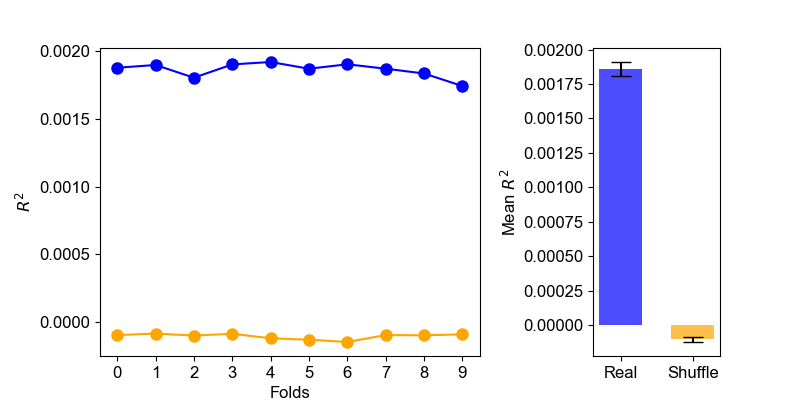

In [81]:
import numpy as np
from scipy import stats

# Plot the R² per fold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.45})

# Line plot showing R² across folds
ax1.plot(cv_R_squared, 'o-', label='real', color='blue', markersize=8)
ax1.plot(np.array(cv_R_squared_shuffle), 'o-', label='shuffle', color='orange', markersize=8)
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('Folds')
ax1.set_xticks(np.arange(0, n_folds))
# ax1.set_title('Model performance across folds')

# Bar plot showing mean R² values
mean_r2_real = np.mean(cv_R_squared)
mean_r2_shuffle = np.mean(cv_R_squared_shuffle)
std_r2_real = np.std(cv_R_squared)
std_r2_shuffle = np.std(cv_R_squared_shuffle)

bar_positions = [0, 1]
bar_heights = [mean_r2_real, mean_r2_shuffle]
bar_errors = [std_r2_real, std_r2_shuffle]

bars = ax2.bar(bar_positions, bar_heights, yerr=bar_errors, width=0.6, 
    color=['blue', 'orange'], capsize=7, alpha=0.7)
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(['Real', 'Shuffle'])
ax2.set_ylabel('Mean $R^2$')
# ax2.set_title('Average performance')

# # Add p-value from t-test 
# t_stat, p_val = stats.ttest_ind(cv_R_squared, cv_R_squared_shuffle)
# if p_val < 0.001:
#     p_text = 'p < 0.001'
# elif p_val < 0.01:
#     p_text = f'p < 0.01'
# elif p_val < 0.05:
#     p_text = f'p < 0.05'
# else:
#     p_text = f'p = {p_val:.3f}'

# y_pos = max(bar_heights) + max(bar_errors) * 1.2
# ax2.text(0.5, y_pos, p_text, ha='center', fontsize=12)

# # Add values on top of bars
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2., height + bar_errors[i] * 0.3,
#          f'{height:.4f}', ha='center', fontsize=10)

plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_model_scores_across_folds.svg"), format='svg', dpi=300, bbox_inches='tight')


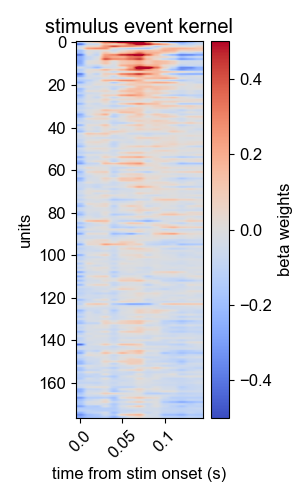

In [73]:
weights = models[best_model].coef_

row_cumsum = np.cumsum(weights[:,:15], axis=1)
row_sort_indices = np.argsort(row_cumsum[:, -1])[::-1]
sorted_model_weights = weights[row_sort_indices]

plt.figure(figsize=(3, 5))
plt.imshow(sorted_model_weights[:,:15], aspect='auto', cmap='coolwarm', vmin = -0.5, vmax = 0.5)
# plt.imshow(weights[:,:15], aspect='auto', cmap='coolwarm')
plt.colorbar(label = 'beta weights')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event kernel')
plt.tight_layout()
plt.savefig(pjoin(save_dir, "stimulus_event_kernel_weights.png"), format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
weights = models[best_model].coef_

row_cumsum = np.cumsum(weights[:,17:], axis=1)
row_sort_indices = np.argsort(row_cumsum[:, -1])[::-1]
sorted_model_weights = weights[row_sort_indices]

plt.figure(figsize=(3, 6))
plt.imshow(sorted_model_weights[:,17:], aspect='auto', cmap='coolwarm', vmin = -0.5, vmax = 0.5)
plt.colorbar(label = 'beta weights')

# Define xticks and xtick_labels with matching lengths
xticks = np.arange(0, 20, 5)  # Creates [0, 5, 10, 15]
xtick_labels = np.arange(-0.1, 0.1, 0.05)  # Creates [-0.1, -0.05, 0.0, 0.05]

plt.xticks(xticks, xtick_labels, rotation = 45)
plt.xlabel('time from response onset (s)')
plt.ylabel('units')
plt.title('response event kernel')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_event_kernel_weights.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
plt.figure()
ax = plt.gca()
plt.scatter(weights[:, 15], weights[:, 16], c='k', marker='o', alpha = 0.5)
plt.axhline(0, 0, 1, color = 'k', linestyle = '--')
plt.axvline(0, 0, 1, color = 'k', linestyle = '--')
plt.xlabel('stationary weight')
plt.ylabel('movement weight')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Scatter plot
plt.scatter(weights[:, 15], weights[:, 16], c='k', marker='o', alpha=0.5)

# Find limits to make plot symmetric around zero
max_abs_val = max(
    abs(weights[:, 15].min()), 
    abs(weights[:, 15].max()),
    abs(weights[:, 16].min()),
    abs(weights[:, 16].max())
)
limit = max_abs_val * 1.1  # Add some margin

# Set equal limits for both axes centered at zero
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)

# Add diagonal line
plt.plot([-limit, limit], [-limit, limit], 'k--', alpha=0.5)

plt.xlabel('stationary weight')
plt.ylabel('movement weight')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Scatter plot
plt.scatter(weights[:, 15], weights[:, 16], c='k', marker='o', alpha=0.5)

# Find limits to make plot symmetric around zero
max_abs_val = max(
    abs(weights[:, 15].min()), 
    abs(weights[:, 15].max()),
    abs(weights[:, 16].min()),
    abs(weights[:, 16].max())
)
limit = max_abs_val * 1.1  # Add some margin

# Set equal limits for both axes centered at zero
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)

# Add diagonal line
plt.plot([-limit, limit], [-limit, limit], 'k--', alpha=0.5)

plt.xlabel('stationary weight')
plt.ylabel('movement weight')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_weights_scatter_centered.png"), format='png', dpi=300, bbox_inches='tight')


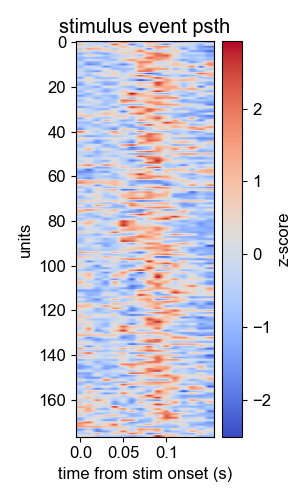

In [ ]:
# pop_peth, timebin_edges, _ = population_peth(
#         all_spike_times=spike_times_per_unit,
#         alignment_times=all_stims,
#         pre_seconds=0.025,
#         post_seconds=post_seconds,
#         binwidth_ms=bin_size*1000,
#         pad=0,
#         kernel=None,
#     )

# mean_psth = pop_peth.mean(axis=1)


# Normalize the PSTH for each unit
normalized_mean_psth = (mean_psth - mean_psth.mean(axis=1, keepdims=True)) / mean_psth.std(axis=1, keepdims=True)
peak_indices = np.argmax(normalized_mean_psth, axis=1)
peak_sort_indices = np.argsort(peak_indices) #row_sort_indices is for cumsum of model weights, peak_sort_indices is for earlier responses
sorted_psth = normalized_mean_psth[peak_sort_indices]

plt.figure(figsize=(3,5))
plt.imshow(normalized_mean_psth, aspect='auto', cmap='coolwarm')
plt.colorbar(label = 'z-score')
xticks = np.arange(0, 15, 5)  
xtick_labels = np.arange(0, 0.15, 0.05)  # Creates [-0.1, -0.05, 0.0, 0.05]
plt.xticks(xticks, xtick_labels)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event psth')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "stimulus_event_psth.png"), format='png', dpi=300, bbox_inches='tight')
